In [3]:
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
from sklearn import feature_selection as fs
from sklearn import metrics
from sklearn.model_selection import cross_validate
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

%matplotlib inline

In [4]:
AWC_Prep = pd.read_csv('Data/AdvWorksCusts_Preped.csv')
print(AWC_Prep.shape)

(16404, 22)


In [5]:
labels = np.array(AWC_Prep['BikeBuyer'])

In [6]:
def encode_string(cat_features):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

categorical_columns = ['LastName','AddressLine1', 'City', 'StateProvinceName', 'CountryRegionName', 'PostalCode','PhoneNumber', 
                       'BirthDate','Education', 'Occupation', 'Gender', 'MaritalStatus','HomeOwnerFlag','AgeRange']
Features = encode_string(AWC_Prep['FirstName'])
for col in categorical_columns:
    temp = encode_string(AWC_Prep[col])
    Features = np.concatenate([Features, temp], axis = 1)

print(Features.shape) 

(16404, 29411)


In [7]:
Features = np.concatenate([Features, np.array(AWC_Prep[['NumberCarsOwned','NumberChildrenAtHome', 
                            'TotalChildren', 'YearlyIncome','Age']])], axis = 1)
print(Features.shape)

(16404, 29416)


In [8]:
Features.shape

(16404, 29416)

We see that there are more features than customers. We need to reduce the number of features to hopefully increase the accuracy

In [9]:
print(Features.shape)

## Define the variance threhold and fit the threshold to the feature array. 
sel = fs.VarianceThreshold(threshold=(.8 * (1 - .8)))
Features_reduced = sel.fit_transform(Features)

## Print the support and shape for the transformed features
print(Features_reduced.shape)

(16404, 29416)
(16404, 18)


In [10]:
Features_reduced

array([[0.00000e+00, 0.00000e+00, 1.00000e+00, ..., 2.00000e+00,
        1.37947e+05, 3.10000e+01],
       [0.00000e+00, 0.00000e+00, 1.00000e+00, ..., 3.00000e+00,
        1.01141e+05, 3.20000e+01],
       [0.00000e+00, 0.00000e+00, 1.00000e+00, ..., 3.00000e+00,
        9.19450e+04, 3.20000e+01],
       ...,
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 3.00000e+00,
        6.04170e+04, 3.70000e+01],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 3.00000e+00,
        6.66530e+04, 3.80000e+01],
       [0.00000e+00, 0.00000e+00, 1.00000e+00, ..., 3.00000e+00,
        5.97360e+04, 3.80000e+01]])

In [11]:
Features_reduced[0,:].size

18

In [12]:
Features_reduced[0,:]

array([0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
       0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
       0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
       2.00000e+00, 1.37947e+05, 3.10000e+01])

Features that were below the Varience Threshold of 0.8 were removed and thus the number of features was reduced from over 29K to 18. 

In [13]:
## Reshape the Label array
labels = labels.reshape(labels.shape[0],)

## Set folds for nested cross validation
nr.seed(988)
feature_folds = ms.KFold(n_splits=10, shuffle = True)

## Define the model
logistic_mod = linear_model.LogisticRegression(C = 10, class_weight = {0:0.45, 1:0.55}) 

## Perform feature selection by CV with high variance features only
nr.seed(6677)
selector = fs.RFECV(estimator = logistic_mod, cv = feature_folds,
                      scoring = 'roc_auc')
selector = selector.fit(Features_reduced, labels)
selector.support_ 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True])

From the support you can see that some features are selected (True) and eliminated (False). 


In [14]:
selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1])

Notice that the features which have been selected are shown with a rank of 1. The features eliminated are shown with higher numbers. 

In [15]:
Features_reduced = selector.transform(Features_reduced)
Features_reduced.shape

(16404, 17)

# Test and Score model

In [16]:
## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features_reduced.shape[0])
indx = ms.train_test_split(indx, test_size = int(16404*0.3))
X_train = Features_reduced[indx[0],:]
y_train = np.ravel(labels[indx[0]])
X_test = Features_reduced[indx[1],:]
y_test = np.ravel(labels[indx[1]])

## Define and fit the logistic regression model
logistic_mod = linear_model.LogisticRegression(class_weight = {0:0.45, 1:0.55}) 
logistic_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 0.45, 1: 0.55}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [17]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

probabilities = logistic_mod.predict_proba(X_test)
print(probabilities[:15,:])
scores = score_model(probabilities, 0.3)

[[0.02220162 0.97779838]
 [0.84784496 0.15215504]
 [0.74183173 0.25816827]
 [0.50635176 0.49364824]
 [0.59782162 0.40217838]
 [0.85432076 0.14567924]
 [0.62084037 0.37915963]
 [0.67220535 0.32779465]
 [0.91292673 0.08707327]
 [0.49959482 0.50040518]
 [0.3095747  0.6904253 ]
 [0.0546717  0.9453283 ]
 [0.76270395 0.23729605]
 [0.08917724 0.91082276]
 [0.53179616 0.46820384]]


                 Confusion matrix
                 Score positive    Score negative
Actual positive      2261              1022
Actual negative       355              1283

Accuracy        0.72
AUC             0.84
Macro precision 0.71
Macro recall    0.74
 
           Positive      Negative
Num case     3283          1638
Precision    0.86          0.56
Recall       0.69          0.78
F1           0.77          0.65


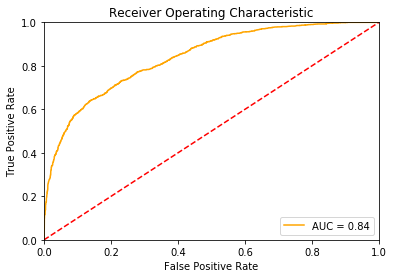

In [18]:
def print_metrics(labels, probs, threshold):
    scores = score_model(probs, threshold)
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, probs[:,1]))
    print('Macro precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()    
        
print_metrics(y_test, probabilities, 0.3)    
plot_auc(y_test, probabilities)   

In [19]:
predict = logistic_mod.predict(X_test)
print(predict[:15])

[1 0 0 0 0 0 0 0 0 1 1 1 0 1 0]


# Load and Prepare Test Data

I will prepare the test data like the Training Data

In [20]:
AW_Test = pd.read_csv('Data/AW_Test.csv')
print(AW_Test.shape)
AW_Test.head(10)

(500, 23)


,CustomerID,Title,FirstName,MiddleName,LastName,Suffix,AddressLine1,AddressLine2,City,StateProvinceName,...,BirthDate,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome
0,18988,NaN,Courtney,A,Baker,NaN,8727 Buena Vista Ave.,NaN,Fremont,California,...,1/5/1945,Bachelors,Management,F,S,0,2,0,5,86931
1,29135,NaN,Adam,C,Allen,NaN,3491 Cook Street,NaN,Haney,British Columbia,...,10/4/1964,Bachelors,Skilled Manual,M,M,1,2,2,4,100125
2,12156,NaN,Bonnie,NaN,Raji,NaN,359 Pleasant Hill Rd,NaN,Burbank,California,...,1/12/1934,Graduate Degree,Management,F,M,1,2,0,4,103985
3,13749,NaN,Julio,C,Alonso,NaN,8945 Euclid Ave.,NaN,Burlingame,California,...,9/22/1958,Graduate Degree,Skilled Manual,M,M,1,0,0,4,127161
4,27780,NaN,Christy,A,Andersen,NaN,"42, boulevard Tremblay",NaN,Dunkerque,Nord,...,3/19/1965,High School,Manual,F,M,1,1,2,2,21876
5,16375,NaN,Gabriella,NaN,Hernandez,NaN,5689 Almondtree Circle,NaN,Spring Valley,California,...,8/23/1957,Partial College,Clerical,F,M,1,1,0,1,44467
6,16109,NaN,Adam,K,Turner,NaN,9800 American Beauty Dr.,NaN,N. Vancouver,British Columbia,...,7/5/1964,Bachelors,Skilled Manual,M,S,1,2,2,4,77702
7,15606,NaN,Marco,C,Prasad,NaN,8523 Rose Drive,C,Cranbourne,Victoria,...,12/11/1964,Bachelors,Professional,M,M,1,3,4,4,99418
8,20888,NaN,Clayton,P,Raje,NaN,"4, place du Tertre",NaN,Tremblay-en-France,Seine Saint Denis,...,1/21/1966,Partial High School,Manual,M,S,1,1,4,4,13522
9,20716,NaN,Kristina,V,Arun,NaN,Waldstr 29,NaN,Hannover,Nordrhein-Westfalen,...,9/13/1973,Bachelors,Skilled Manual,F,M,1,1,1,1,46264


Just like in the test data, Title, MiddleName, Suffix, and AddressLine2 has many missing values so I will drop the columns since the missing values will bias the models

In [21]:
AW_Test.drop(['Title','MiddleName','Suffix','AddressLine2'], axis = 1,inplace=True)
AW_Test.head(10)

,CustomerID,FirstName,LastName,AddressLine1,City,StateProvinceName,CountryRegionName,PostalCode,PhoneNumber,BirthDate,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome
0,18988,Courtney,Baker,8727 Buena Vista Ave.,Fremont,California,United States,94536,133-555-0128,1/5/1945,Bachelors,Management,F,S,0,2,0,5,86931
1,29135,Adam,Allen,3491 Cook Street,Haney,British Columbia,Canada,V2W 1W2,252-555-0173,10/4/1964,Bachelors,Skilled Manual,M,M,1,2,2,4,100125
2,12156,Bonnie,Raji,359 Pleasant Hill Rd,Burbank,California,United States,91502,409-555-0193,1/12/1934,Graduate Degree,Management,F,M,1,2,0,4,103985
3,13749,Julio,Alonso,8945 Euclid Ave.,Burlingame,California,United States,94010,175-555-0196,9/22/1958,Graduate Degree,Skilled Manual,M,M,1,0,0,4,127161
4,27780,Christy,Andersen,"42, boulevard Tremblay",Dunkerque,Nord,France,59140,1 (11) 500 555-0122,3/19/1965,High School,Manual,F,M,1,1,2,2,21876
5,16375,Gabriella,Hernandez,5689 Almondtree Circle,Spring Valley,California,United States,91977,165-555-0161,8/23/1957,Partial College,Clerical,F,M,1,1,0,1,44467
6,16109,Adam,Turner,9800 American Beauty Dr.,N. Vancouver,British Columbia,Canada,V7L 4J4,222-555-0116,7/5/1964,Bachelors,Skilled Manual,M,S,1,2,2,4,77702
7,15606,Marco,Prasad,8523 Rose Drive,Cranbourne,Victoria,Australia,3977,1 (11) 500 555-0165,12/11/1964,Bachelors,Professional,M,M,1,3,4,4,99418
8,20888,Clayton,Raje,"4, place du Tertre",Tremblay-en-France,Seine Saint Denis,France,93290,1 (11) 500 555-0188,1/21/1966,Partial High School,Manual,M,S,1,1,4,4,13522
9,20716,Kristina,Arun,Waldstr 29,Hannover,Nordrhein-Westfalen,Germany,30601,1 (11) 500 555-0186,9/13/1973,Bachelors,Skilled Manual,F,M,1,1,1,1,46264


The column BirthDate should be of datetime type to ease later calculations

In [22]:
AW_Test['BirthDate'] = pd.to_datetime(AW_Test['BirthDate'])
AW_Test.dtypes

CustomerID                       int64
FirstName                       object
LastName                        object
AddressLine1                    object
City                            object
StateProvinceName               object
CountryRegionName               object
PostalCode                      object
PhoneNumber                     object
BirthDate               datetime64[ns]
Education                       object
Occupation                      object
Gender                          object
MaritalStatus                   object
HomeOwnerFlag                    int64
NumberCarsOwned                  int64
NumberChildrenAtHome             int64
TotalChildren                    int64
YearlyIncome                     int64
dtype: object

Next we add the Age and AgeRange since we added those to the training data

In [23]:
AW_Test['Age'] = ((pd.to_datetime('01/01/1998')-AW_Test['BirthDate'])/365).dt.days
bins = [0,24,45,55, np.inf]
names = ['<25','25-45','45-55','55+']
AW_Test['AgeRange'] = pd.cut(AW_Test['Age'], bins, labels=names)
AW_Test.head(10)

,CustomerID,FirstName,LastName,AddressLine1,City,StateProvinceName,CountryRegionName,PostalCode,PhoneNumber,BirthDate,...,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,Age,AgeRange
0,18988,Courtney,Baker,8727 Buena Vista Ave.,Fremont,California,United States,94536,133-555-0128,1945-01-05,...,Management,F,S,0,2,0,5,86931,53,45-55
1,29135,Adam,Allen,3491 Cook Street,Haney,British Columbia,Canada,V2W 1W2,252-555-0173,1964-10-04,...,Skilled Manual,M,M,1,2,2,4,100125,33,25-45
2,12156,Bonnie,Raji,359 Pleasant Hill Rd,Burbank,California,United States,91502,409-555-0193,1934-01-12,...,Management,F,M,1,2,0,4,103985,64,55+
3,13749,Julio,Alonso,8945 Euclid Ave.,Burlingame,California,United States,94010,175-555-0196,1958-09-22,...,Skilled Manual,M,M,1,0,0,4,127161,39,25-45
4,27780,Christy,Andersen,"42, boulevard Tremblay",Dunkerque,Nord,France,59140,1 (11) 500 555-0122,1965-03-19,...,Manual,F,M,1,1,2,2,21876,32,25-45
5,16375,Gabriella,Hernandez,5689 Almondtree Circle,Spring Valley,California,United States,91977,165-555-0161,1957-08-23,...,Clerical,F,M,1,1,0,1,44467,40,25-45
6,16109,Adam,Turner,9800 American Beauty Dr.,N. Vancouver,British Columbia,Canada,V7L 4J4,222-555-0116,1964-07-05,...,Skilled Manual,M,S,1,2,2,4,77702,33,25-45
7,15606,Marco,Prasad,8523 Rose Drive,Cranbourne,Victoria,Australia,3977,1 (11) 500 555-0165,1964-12-11,...,Professional,M,M,1,3,4,4,99418,33,25-45
8,20888,Clayton,Raje,"4, place du Tertre",Tremblay-en-France,Seine Saint Denis,France,93290,1 (11) 500 555-0188,1966-01-21,...,Manual,M,S,1,1,4,4,13522,31,25-45
9,20716,Kristina,Arun,Waldstr 29,Hannover,Nordrhein-Westfalen,Germany,30601,1 (11) 500 555-0186,1973-09-13,...,Skilled Manual,F,M,1,1,1,1,46264,24,<25




Want to find the duplicate values and only keep the first occurance. There are only unique values in the test set so we are good to go

In [24]:
print(AW_Test.shape)
print(AW_Test.CustomerID.unique().shape)

(500, 21)
(500,)


In [25]:
def encode_string(cat_features):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

categorical_columns = ['LastName','AddressLine1', 'City', 'StateProvinceName', 'CountryRegionName', 'PostalCode','PhoneNumber', 
                       'BirthDate','Education', 'Occupation', 'Gender', 'MaritalStatus','HomeOwnerFlag','AgeRange']
Features_Test = encode_string(AW_Test['FirstName'])
for col in categorical_columns:
    temp = encode_string(AW_Test[col])
    Features_Test = np.concatenate([Features_Test, temp], axis = 1)

print(Features_Test.shape) 

(500, 2291)


In [26]:
Features_Test = np.concatenate([Features_Test, np.array(AW_Test[['NumberCarsOwned','NumberChildrenAtHome', 
                            'TotalChildren', 'YearlyIncome','Age']])], axis = 1)
print(Features_Test.shape)

(500, 2296)


We see that there are more features than customers. We need to reduce the number of features to hopefully increase the accuracy

In [27]:
print(Features_Test.shape)

## Define the variance threhold and fit the threshold to the feature array. 
Ft_reduced = sel.fit_transform(Features_Test)

## Print the support and shape for the transformed features
print(Ft_reduced.shape)

(500, 2296)
(500, 18)


In [28]:
Ft_reduced = selector.transform(Ft_reduced)
Ft_reduced.shape

(500, 17)

In [29]:
pred_test = logistic_mod.predict(Ft_reduced)

In [30]:
pd.DataFrame(pred_test).to_csv('final_answers.csv', header = False, index = False)